<a href="https://colab.research.google.com/github/ericpapain/DiscriminationTweetsProject/blob/Eric/Bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### Initialisation de Collab dans mon drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Import dataset and librairies**

#### *1.1 Import Librairies*

In [3]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 14.0MB/s 


In [36]:
import pandas as pd
import numpy as np
import re
from spellchecker import SpellChecker
import requests
from datetime import datetime

#### *1.2 Import dataset*

In [37]:
dataset = pd.read_csv('discrimination.csv', sep=',')

In [38]:
discriminant_Dataset = dataset.iloc[:,[1,3]]

In [ ]:
discriminant_Dataset.sample

## **2. Tokenization and Input Formatting**

In [55]:
def data_cleaning(dataset):
    '''
        df : DataFrame 
    '''
    #capture du temps d'exécution du programme
    start_time = datetime.now()
    for i in range(len(dataset)):
        # Mise en minuscule 
        dataset['Tweets'][i] = dataset['Tweets'][i].lower()
        #suppression des carractère spéciaux
        dataset['Tweets'][i]=re.sub(r'(&#[0-9]*;)', ' ',dataset['Tweets'][i])
        #suppression des annotations, des noms et tag inutile
        dataset['Tweets'][i]=re.sub(r'(@.*?)[\s]', ' ',dataset['Tweets'][i])
        #dataset['Tweet'][i]=re.sub(r'(&.*?)[\s]', ' ',dataset['Tweet'][i])
        # Replace '&amp;' par '&'
        dataset['Tweets'][i] = re.sub(r'&amp;', '&', dataset['Tweets'][i])
        #suppression urls
        dataset['Tweets'][i]=re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ',dataset['Tweets'][i])
        #suppression des retweets
        dataset['Tweets'][i]=re.sub(r'rt', ' ',dataset['Tweets'][i])
        # Suppression des espaces de fin de ligne
        dataset['Tweets'][i] = re.sub(r'\s+', ' ', dataset['Tweets'][i]).strip()
        #dataset['Tweets'][i]=re.sub(r'#', ' ',dataset['Tweets'][i])
        # suppression des carractères spéciaux et de la ponctuation 
        #dataset['Tweets'][i] = re.sub(r'(ð|ÿ|⇒|¬|œ|¦|€|˜|™|¸|¤|©|¡|…|”|“|‹|š|±|³|iâ|§|„|~|-|æ|«|€|¶|ŧ|←|↓|→|ø|þ|@|ß|ð|đ|ŋ|ħ|ł|µ|ł|»|¢|)', ' ', dataset['Tweets'][i]) 
        
    #capture temps de fin
    end_time = datetime.now()
    print(">>>>> le data cleanning à pris :",(end_time-start_time)," secondes.")
    return dataset

### *- Remplace word abreviation and verlang*

In [56]:
#parcours de chaque mot dans un tweet
def remplace_word_abbreviation(dataset_clean,file_txt):
    
    start_time = datetime.now()
    
    list_word=[]
    new_list_word=[]
    dico_word_abrev={}
    #chargement du dico des abrev
    a_file = open(file_txt)

    for line in a_file:
        value = line.split(",")
        #list_word.append(value)
    for val in value:
        valN = val.strip("{}")
        list_word.append(valN)
    for val in list_word:
        valN = val.split(":")
        try:
            key = valN[0]
            val_key = valN[1]
            dico_word_abrev[key] = val_key
        except:
            #print(key, "------------------------",val_key)
            del val
            pass
    
    for word_dico,values in dico_word_abrev.items():
        for i in range(len(dataset_clean)):
            tweet = list((dataset_clean['Tweets'][i]).split())
            #positionnement au premier mot
            j=0
            for word in tweet:
                #recupération du mot en non abrégé
                if(word == word_dico):
                    #remplacement dans le tweet
                    tweet[j]=values
                #tweet suivant
                j=j+1
            if(j==0):
                pass
            else:
                #mise a jour du tweet dans le dataset
                dataset['Tweets'][i] = ' '.join(tweet)
            #if(i==len(dataset_clean)-1):
                #print(i)
    
    end_time = datetime.now()
    print(">>>>> le remplacement des mots abégé et ecris en argo à pris :",(end_time-start_time)," secondes.")

    return dataset

### *- Spelling word*

In [57]:
#recherche de mot mal écrit
def spelling_word_in_tweet(dataset_clean):
    
    start_time = datetime.now()
    
    spell = SpellChecker(language='en',distance=1)
    dico_correction_orthographe = {}
    
    for i in range(len(dataset_clean)):
        tweet = list((dataset_clean['Tweets'][i]).split())
        j=0
        for word in tweet:
            # Get the one `most likely` answer
            #print("next : ",word," newww :",spell.correction(word))
            mot = spell.correction(word)
            # Get a list of `likely` options
           # print(spell.candidates(word))
            if(mot==word):
                pass
            else:
                #construction du dico des abréviation trouvé
                #print(mot,word)
                dico_correction_orthographe[word]=mot
                tweet[j]=mot
                #print("tweet number : ",i," i was :",word," now i'm ",true_val)
            j=j+1
            #print(r.text[startIndex:endIndex])
        if(j==0):
            pass
        else:
            #mise a jour du tweet
            dataset_clean['Tweets'][i] = ' '.join(tweet)
            dataset_clean['Tweets'][i] = dataset_clean['Tweets'][i].lower()
        #if((i+1)%len(dataset_clean)==0):
            #print(i,": tous les tweets ont été corrigé !!!")
    
    end_time = datetime.now()
    print(">>>>> le remplacement des mots mal écris ( fautes d'othographes et de grammaires) à pris :",(end_time-start_time)," secondes.")
    
    return dico_correction_orthographe, dataset

In [64]:
def traitemnet_before_bert_tokenization(dataset):
    #import file abrev 
    file = "dico_abrev.txt"
    # small cleaning
    dataset_clean=data_cleaning(dataset)
    # abreviation subtitution
    dataset_with_abrev_ok=remplace_word_abbreviation(dataset_clean,file)
    # manage spelling word
    _, dataset_spell_ok=spelling_word_in_tweet(dataset_with_abrev_ok)
    
    return dataset_spell_ok

In [65]:
#small traitemnt
discriminant_Dataset = traitemnet_before_bert_tokenization(discriminant_Dataset)

>>>>> le remplacement des mots abégé et ecris en argo à pris : 0:48:57.432129  secondes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


>>>>> le remplacement des mots mal écris ( fautes d'othographes et de grammaires) à pris : 0:00:55.512227  secondes.


In [81]:
# divided our dataset in test and train
discriminant_Dataset['split']= np.random.randn(discriminant_Dataset.shape[0], 1)
msk = np.random.rand(len(discriminant_Dataset)) <= 0.9
#data_train and data_test
data_train = discriminant_Dataset[msk]
data_test = discriminant_Dataset[~msk]

data_train = data_train.iloc[:,[1,3]]
data_test = data_test.iloc[:,[1,3]]

#### *Training/Validation Split*


In [82]:
from sklearn.model_selection import train_test_split

In [83]:
#for discriminant data
X_discri_train, X_discri_val, y_discri_train, y_discri_val = train_test_split(data_train['Tweets'], 
                                                  data_train['Labels'], 
                                                  test_size=0.10, 
                                                  random_state=2020, 
                                                  stratify=data_train['Labels'])

#### *2.1. BERT Tokenizer*

In [85]:
!pip install transformers

     |████████████████████████████████| 1.5MB 16.4MB/s 
     |████████████████████████████████| 2.9MB 51.7MB/s 
     |████████████████████████████████| 890kB 45.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b53c66f4c9e1577eb26d59280a147cc6b8b95f7878c528c90b6bfc4df4d3e347
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [86]:
from transformers import BertTokenizer
import torch
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [126]:
#extraction of ours tweet
all_tweets = dataset.Tweets.values
# Encode our dataset in a list for finding a max lenght of our dataset
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length of tweet after encoding
MAX_LEN = max([len(sent) for sent in encoded_tweets])
print('Max length: ', MAX_LEN)

Max length:  61


In [127]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data_after_clean):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    start_time = datetime.now()
    
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data_after_clean:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            sent,                           # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    end_time = datetime.now()
    print(">>>>> La Tokenization à pris :",(end_time-start_time)," secondes.")
    
    return input_ids, attention_masks

### -------------Tokenize our data.

In [128]:
# Run function `preprocessing_for_bert` on the train set and the validation set for discriminant dataset
print('Tokenizing data...')
train_discr_inputs, train_discr_masks = preprocessing_for_bert(X_discri_train)
val_discr_inputs, val_discr_masks = preprocessing_for_bert(X_discri_val)

Tokenizing data...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


>>>>> La Tokenization à pris : 0:00:07.288274  secondes.
>>>>> La Tokenization à pris : 0:00:00.796605  secondes.


### **2.2. Create PyTorch DataLoader**

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [129]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

In [130]:
# Convert other data types to torch.Tensor for discrimination dataset
train_discri_labels = torch.tensor(y_discri_train.values)
val_discri_labels = torch.tensor(y_discri_val.values)

# Create the DataLoader for our training set for discrimination dataset
train_discri_data = TensorDataset(train_discr_inputs, train_discr_masks, train_discri_labels)
train_d_sampler = RandomSampler(train_discri_data)
train_discri_dataloader = DataLoader(train_discri_data, sampler=train_d_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set for discrimination dataset
val_discri_data = TensorDataset(val_discr_inputs, val_discr_masks, val_discri_labels)
val_d_sampler = SequentialSampler(val_discri_data)
val_discri_dataloader = DataLoader(val_discri_data, sampler=val_d_sampler, batch_size=batch_size)

## **3. Train Our Model**

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

#### *3.1. Create BertClassifier*

In [131]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 100, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 34 µs, sys: 7 µs, total: 41 µs
Wall time: 45.1 µs


#### *3.2. Optimizer & Learning Rate Scheduler*

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the run_glue.py script, an examples of implementing the transformers library. In the script, the AdamW optimizer is used.



In [132]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU or cpu
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #choice of CPU or GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_discri_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

#### *3.3. Training Loop*

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (loss.backward())
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (optimizer.step())
- Update the learning rate (scheduler.step())

Evaluation:

- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop.

In [134]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    start_time = datetime.now()
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            # Tell PyTorch to run the model on GPU or cpu
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            # Load batch to GPU or CPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    end_time = datetime.now()
    print(">>>>>Training complete! in ",(end_time-start_time)," secondes.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Tell PyTorch to run the model on GPU or cpu
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Load batch to GPU or CPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

#### **----Now, let's start training our BertClassifier!**

In [135]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_discri_dataloader, val_discri_dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.592653   |     -      |     -     |   7.28   
   1    |   40    |   0.453967   |     -      |     -     |   6.92   
   1    |   60    |   0.384556   |     -      |     -     |   7.00   
   1    |   80    |   0.357267   |     -      |     -     |   7.07   
   1    |   100   |   0.362626   |     -      |     -     |   7.10   
   1    |   120   |   0.353208   |     -      |     -     |   7.15   
   1    |   140   |   0.391802   |     -      |     -     |   7.23   
   1    |   160   |   0.360456   |     -      |     -     |   7.30   
   1    |   180   |   0.334347   |     -      |     -     |   7.39   
   1    |   200   |   0.354172   |     -      |     -     |   7.43   
   1    |   220   |   0.348727   |     -      |     -     |   7.51   
   1    |   240   |   0.324600   |     -      |     -     |   7.52   


## 3.4. Evaluation on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [136]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Tell PyTorch to run the model on GPU or cpu
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Load batch to GPU or cpu
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [141]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9301
Accuracy: 89.12%


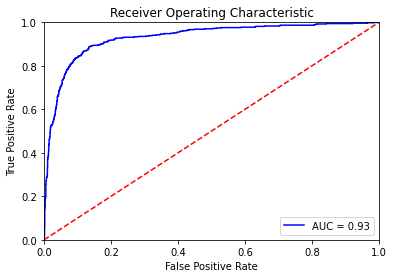

In [142]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_discri_dataloader)
# Evaluate the Bert classifier
evaluate_roc(probs, y_discri_val)

### **3.5. Train Our Model on the Entire Training Data**¶


In [143]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_discri_data, val_discri_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, full_train_dataloader, epochs=4)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.554313   |     -      |     -     |   7.85   
   1    |   40    |   0.394482   |     -      |     -     |   7.67   
   1    |   60    |   0.415003   |     -      |     -     |   7.81   
   1    |   80    |   0.431460   |     -      |     -     |   7.75   
   1    |   100   |   0.407126   |     -      |     -     |   7.61   
   1    |   120   |   0.348311   |     -      |     -     |   7.44   
   1    |   140   |   0.350590   |     -      |     -     |   7.34   
   1    |   160   |   0.292606   |     -      |     -     |   7.30   
   1    |   180   |   0.387515   |     -      |     -     |   7.29   
   1    |   200   |   0.368568   |     -      |     -     |   7.33   
   1    |   220   |   0.360253   |     -      |     -     |   7.36   
   1    |   240   |   0.319501   |     -      |     -     |   7.44   


### **4. Predictions on Test Set**¶


In [144]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(data_test.Tweets)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


>>>>> La Tokenization à pris : 0:00:01.001654  secondes.


### **4.2. Predictions**

In [147]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets bad predicted: ", preds.sum())

Number of tweets bad predicted:  562
